# Import Libraries

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset

In [49]:
import multiprocessing

print(f'Number of kernels in cpu: {multiprocessing.cpu_count()}')

Number of kernels in cpu: 8


# Load Data

In [3]:
# Read Dataframe from .csv file
data = pd.read_csv('train.csv')

# Dataset Shape and Preview of the first 5 rows
print('Dataframe shape:', data.shape)
data.head()

Dataframe shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


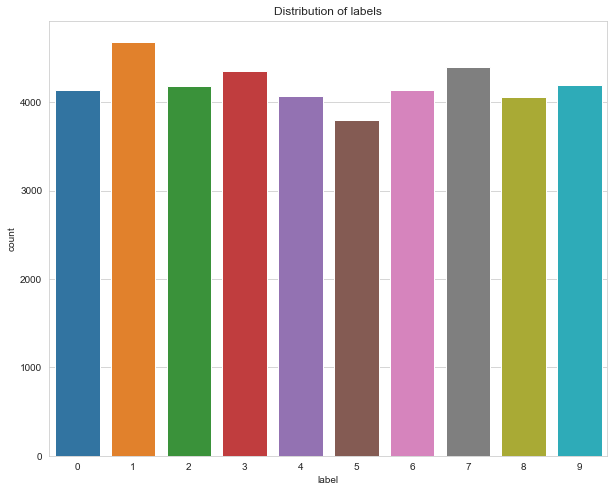

In [6]:
plt.figure(figsize=(10,8))
sns.countplot(x=data['label'])
plt.title('Distribution of labels')
plt.show()

In [28]:
from numpy.random._examples.cffi.extending import rng

dict_labels = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}
for i in range(data.shape[0]):
        digit = str(data.iloc[i]['label'])
        dict_labels[digit].append(i)

train_index = []
valid_index = []
for i in dict_labels:
        shuffled_indices = rng.permutation(dict_labels[i])
        indexes_train = shuffled_indices[:3500]
        indexes_valid = shuffled_indices[3500:]
        train_index = [*train_index, *indexes_train]
        valid_index = [*valid_index, *indexes_valid]

train_index = rng.permutation(train_index)
valid_index = rng.permutation(valid_index)

In [38]:
y_train = data.iloc[train_index]['label'].to_numpy()
y_valid = data.iloc[valid_index]['label'].to_numpy()

X_train = data.iloc[train_index].drop(columns=['label']).to_numpy()
X_valid = data.iloc[valid_index].drop(columns=['label']).to_numpy()

print(X_train.shape)
print(y_train.shape)

(35000, 784)
(35000,)


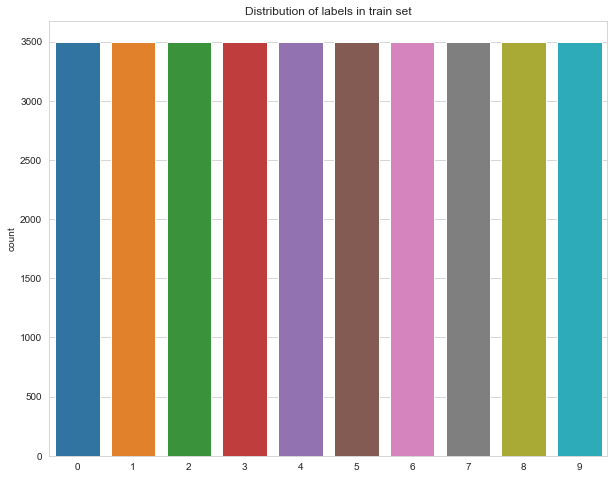

In [39]:
plt.figure(figsize=(10,8))
sns.countplot(x=y_train)
plt.title('Distribution of labels in train set')
plt.show()

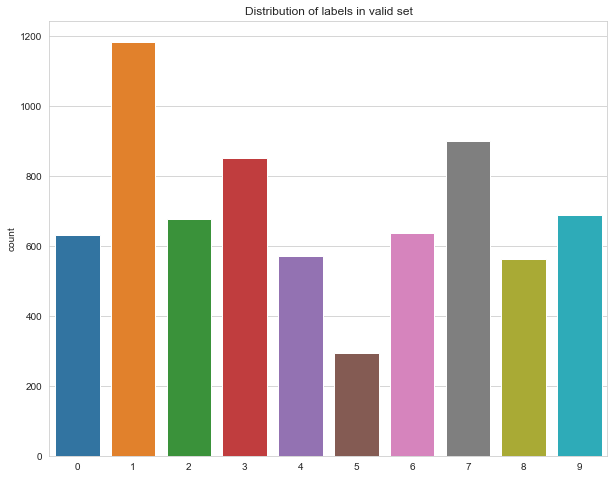

In [40]:
plt.figure(figsize=(10,8))
sns.countplot(x=y_valid)
plt.title('Distribution of labels in valid set')
plt.show()

# Dimensionality Reduction

In [45]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()
# PCA for dimensionality redcution (non-visualization)
pca.n_components = 784
pca_data = pca.fit_transform(X_train)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

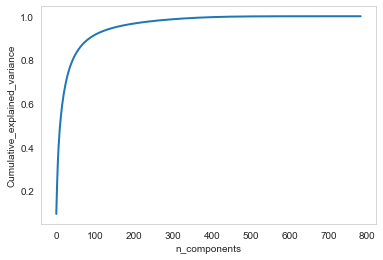

In [46]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [164]:
from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_train / 255)

/Users/sergiotallotorres/PycharmProjects/kaggle_competitions/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sergiotallotorres/PycharmProjects/kaggle_competitions/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


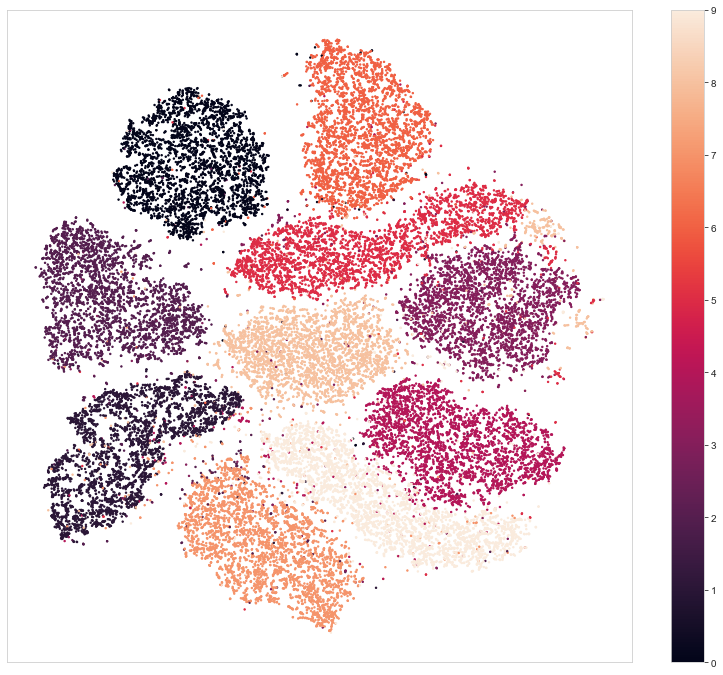

In [165]:
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_train, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar()

# Train KNN

In [166]:
for k in range(1, 46):
        start_time = datetime.now()
        neigh = KNeighborsClassifier(n_neighbors=k, algorithm='auto', n_jobs=8)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_valid)

        my_accuracy = accuracy_score(y_valid, y_pred)
        end_time = datetime.now()
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds()

        print(f'Num. of neighbors: {k} / Accuracy in Validation set: {my_accuracy:.3f} / time: {execution_time:.3f} sec')

ValueError: X has 784 features, but KNeighborsClassifier is expecting 2 features as input.

In [60]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='auto', n_jobs=8)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=8, n_neighbors=1)

In [61]:
# Read Dataframe from .csv file
test_data = pd.read_csv('test.csv').to_numpy()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [62]:
y_pred = neigh.predict(test_data)

In [73]:
final_df = pd.DataFrame(y_pred, columns=['label'])
final_df.insert(0, 'ImageId', range(1, len(final_df)+1))
final_df.shape

(28000, 2)

In [74]:
final_df.head()

,ImageId,label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [76]:
final_df.to_csv('final_df_knn.csv', index=False)

# CNN

In [218]:
print(X_train.shape)
X_train_img = X_train.reshape(35000, 1, 28, 28) / 255
print(X_train_img.shape)

print(X_valid.shape)
X_valid_img = X_valid.reshape(7000, 1, 28, 28) / 255
print(X_valid_img.shape)

test_data = pd.read_csv('test.csv').to_numpy()
print(test_data.shape)
test_data_img = test_data.reshape(28000, 1, 28, 28) / 255
print(test_data_img.shape)

(35000, 784)
(35000, 1, 28, 28)
(7000, 784)
(7000, 1, 28, 28)
(28000, 784)
(28000, 1, 28, 28)


In [207]:
from torch.utils.data import DataLoader


loader_train = DataLoader(
        dataset=torch.utils.data.TensorDataset(torch.Tensor(X_train_img), torch.Tensor(y_train)),
        batch_size=16,
        shuffle=True,
        num_workers=8
)

loader_valid = DataLoader(
        dataset=torch.utils.data.TensorDataset(torch.Tensor(X_valid_img), torch.Tensor(y_valid)),
        batch_size=16,
        shuffle=True,
        num_workers=8
)

In [181]:
# your code goes here
def CNN_output_size(inputsize: tuple, kernelsize: int, padding:int = 0, stride: int = 1, max_pool_kernel: int = 1):

        dim_X = int((inputsize[0] - kernelsize + (2 * padding)) / stride) + 1
        dim_Y = int((inputsize[1] - kernelsize + (2 * padding)) / stride) + 1

        assert (type(dim_X) == int) and (type(dim_Y) == int)

        return int(dim_X / max_pool_kernel), int(dim_Y / max_pool_kernel)

In [214]:
from torch.nn.functional import binary_cross_entropy
from tqdm import tqdm
def sigmoid(x): return (1 + (-x).exp()).reciprocal()


# your code goes here
class SimpleCNN(torch.nn.Module):
        def __init__(self, size_linear_input):
                super().__init__()
                self.conv1 = torch.nn.Conv2d(1, 16, 3)
                self.conv2 = torch.nn.Conv2d(16, 32, 3)
                self.conv3 = torch.nn.Conv2d(32, 32, 3)
                self.fc1 = torch.nn.Linear(32 * size_linear_input[0] * size_linear_input[1], 96)
                self.fc2 = torch.nn.Linear(96, 10)

                self.linearinputsize = size_linear_input[0] * size_linear_input[1]

        def forward(self, x: torch.Tensor) -> torch.Tensor:

                x = self.conv1(x)
                x = torch.relu(x)
                x = torch.max_pool2d(x, 2, 2)

                x = self.conv2(x)
                x = torch.relu(x)
                x = torch.max_pool2d(x, 2, 2)

                x = self.conv3(x)
                x = torch.relu(x)

                x = x.view(-1, 32 * self.linearinputsize)

                x = torch.relu(self.fc1(x))

                return self.fc2(x)

one = CNN_output_size(inputsize=(28, 28), kernelsize=3, max_pool_kernel=2)
two = CNN_output_size(one, kernelsize=3, max_pool_kernel=2)
three = CNN_output_size(two, kernelsize=3)
CNN = SimpleCNN(three)


n_epochs = 50
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr=learning_rate)

train = []
valid = []

early_stop = 0
best_test = 99999

for e in range(1, n_epochs + 1):
        print(f'Epoch: {e} of {n_epochs}')

        CNN.train()

        for i in loader_train:

                optimizer.zero_grad()

                input = i[0]
                target = i[1].long()

                net_out = CNN(input)

                # Compute loss
                loss = criterion(net_out, target)

                # Backpropagation
                loss.backward()

                # Optimization
                optimizer.step()

        losses_train = []
        CNN.eval()
        correct_t = 0
        with torch.no_grad():
                for i in loader_train:
                        input = i[0]
                        target = i[1].long()

                        net_out = CNN(input)
                        pred = net_out.max(1, keepdim=True)[1]

                        # Compute loss
                        losses_train.append(criterion(net_out, target).item())
                        correct_t += int(pred.eq(target.view_as(pred)).sum().item())


        losses_valid = []
        correct_v = 0
        with torch.no_grad():
                for i in loader_valid:
                        input = i[0]
                        target = i[1].long()

                        net_out = CNN(input)
                        pred = net_out.max(1, keepdim=True)[1]

                        # Compute loss
                        losses_valid.append(criterion(net_out, target).item())
                        correct_v += int(pred.eq(target.view_as(pred)).sum().item())


        # Print result of current epoch to standard out.
        print(f'Train loss: {np.mean(losses_train):.4f} / Train accuracy: {correct_t/X_train.shape[0]:.4f} / Valid loss: {np.mean(losses_valid):.4f} / Valid accuracy: {correct_v/X_valid.shape[0]:.4f}')

        if np.mean(losses_valid) < best_test:
                best_test = np.mean(losses_valid)
                torch.save(CNN, 'model_CNN.pt')
                print(f'save at: {e + 1}')
                early_stop = 0
        else:
                early_stop += 1

        if early_stop > 5:
                break

Epoch: 1 of 50
Train loss: 0.3186 / Train accuracy: 0.8971 / Valid loss: 0.3259 / Valid accuracy: 0.8997
save at: 2
Epoch: 2 of 50
Train loss: 0.1668 / Train accuracy: 0.9457 / Valid loss: 0.1725 / Valid accuracy: 0.9449
save at: 3
Epoch: 3 of 50
Train loss: 0.1043 / Train accuracy: 0.9675 / Valid loss: 0.1230 / Valid accuracy: 0.9613
save at: 4
Epoch: 4 of 50
Train loss: 0.0754 / Train accuracy: 0.9766 / Valid loss: 0.0913 / Valid accuracy: 0.9697
save at: 5
Epoch: 5 of 50
Train loss: 0.0629 / Train accuracy: 0.9803 / Valid loss: 0.0901 / Valid accuracy: 0.9700
save at: 6
Epoch: 6 of 50
Train loss: 0.0627 / Train accuracy: 0.9804 / Valid loss: 0.0903 / Valid accuracy: 0.9716
Epoch: 7 of 50
Train loss: 0.0854 / Train accuracy: 0.9709 / Valid loss: 0.1137 / Valid accuracy: 0.9643
Epoch: 8 of 50
Train loss: 0.0424 / Train accuracy: 0.9873 / Valid loss: 0.0695 / Valid accuracy: 0.9777
save at: 9
Epoch: 9 of 50
Train loss: 0.0593 / Train accuracy: 0.9819 / Valid loss: 0.0873 / Valid accura

In [226]:
challenge_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(torch.Tensor(test_data_img)),
        batch_size=1,
        shuffle=False,
        num_workers=8
)

In [238]:
predictions = []
with torch.no_grad():
        for i in tqdm(challenge_loader):
                input = i[0]
                net_out = CNN(input)
                predictions.append(int(net_out.max(1, keepdim=True)[1]))

print(predictions)

100%|██████████| 28000/28000 [00:12<00:00, 2299.47it/s]

[2, 0, 9, 9, 3, 9, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 5, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 5, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 5, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 9, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

In [239]:
final_df = pd.DataFrame(predictions, columns=['label'])
final_df.insert(0, 'ImageId', range(1, len(final_df)+1))
final_df.shape

(28000, 2)

In [240]:
final_df.head()

,ImageId,label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [241]:
final_df.to_csv('final_df_cnn.csv', index=False)